# Training Models
- github colab : https://homl.info/colab3
- 수학을 잘 몰라도 이 챕터는 읽으라는 말을 보니 대략 중요한 내용이 나오긴 하는 듯

## 여기에서 다루는 regression
- linear regression
- polynomial regression
- logistic regression
- softmax regresssion

## Linear regression 을 training 하는 방법
- 'closed-form'을 사용해서 train하는 방법. 이 경우는 최적의 parameter를 직접 계산한다
    - closed-form : A closed-form equation is only composed of a finite number of constants, variables, and standard operations: for example, a = sin(b – c). No infinite sums, no limits, no integrals, etc
- Gradient Descent를 이용해서 iterative하게 최적의 parameter를 알아내는 법. 


In [15]:
import matplotlib
import matplotlib.pyplot
import pathlib

matplotlib.pyplot.rc('font', size=14)
matplotlib.pyplot.rc('axes', labelsize=14, titlesize=14)
matplotlib.pyplot.rc('legend', fontsize=14)
matplotlib.pyplot.rc('xtick', labelsize=10)
matplotlib.pyplot.rc('ytick', labelsize=10)

output_dir = pathlib.Path() / "images" / "training_linear_models"
output_dir.mkdir(parents=True, exist_ok=True)
print(f'output_dir : {output_dir}')

def matplotlib_to_imagefile(output_dir, filename, imgext="png", tight_layout=True, resolution=300):
    path = output_dir / f"{filename}.{imgext}"
    if tight_layout:
        matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig(path, format=imgext, dpi=resolution)

output_dir : images\training_linear_models


### Loss function vs Evaluation
- Learning을 최적화 하기 위한 Loss function과 모델을 평가하기 위한 기준은 서로 다를 수 있다
- Learning을 잘하기 위해서는 최종적으로 사용하기 위한 기준에 맞춰서 loss function을 설계해야 한다. 여기에서 많이 사용되는게 log loss같은 것이라고 함
- 하지만 다 만든 모델을 evaluate할때에는 precision-recall (classification같은 경우) 을 결국 사용한다
- 근데 loss function을 적절하게 사용한다면 어차피 loss function을 줄이는게 최종적인 evaluation score를 높이는 결과가 된다
- 뭐 어쨌든 두개는 서로 다를 수 있다라는걸 기억하고 넘어갈 만한듯

### Normal Equation
- Linear regression에서 MSE를 minimize하기 위한 closed-form solution. 다음과 같이 구할 수 있다
    - $ \boldsymbol{\theta} = (\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T \boldsymbol{y} $

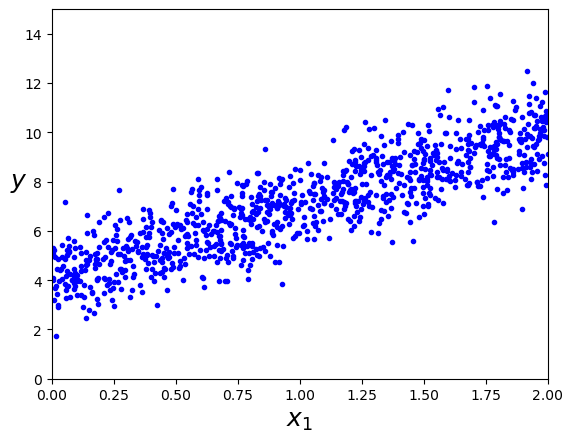

In [16]:
# linear해 보이는 random data만들어서 시험해 보기

import numpy

m = 1000
X = 2 * numpy.random.rand(m, 1)          # rand  : uniform distribution [0,1]
y = 4 + 3 * X + numpy.random.randn(m, 1) # randn : normal distribution  [0,1]

matplotlib.pyplot.plot(X, y, "b.")
matplotlib.pyplot.xlabel("$x_1$", fontsize=18)
matplotlib.pyplot.ylabel("$y$", rotation=0, fontsize=18)
matplotlib.pyplot.axis([0, 2, 0, 15])  # [xmin, xmax, ymin, ymax]
matplotlib.pyplot.show()

In [17]:
import sklearn.preprocessing

print(X[:3])
X_b = sklearn.preprocessing.add_dummy_feature(X) # bias를 추가하기 위해서 각 row에 1을 추가
print(X_b[:3])

# 아래는 다음과 같다. @는 matrix multiplication
# *는 matrix multiplication이 아니다. 예를 들어 A*B=C라고 하면 C[x][y] = A[x][y] * B[x][y] 이다
# theta_best = numpy.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best = numpy.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
print(theta_best) # 위의 generation 예상대로 y=4, x=3에 근접하게 나온다

[[1.31654003]
 [1.18584582]
 [1.94430748]]
[[1.         1.31654003]
 [1.         1.18584582]
 [1.         1.94430748]]
[[4.08996303]
 [2.97655156]]


In [19]:
X_new = numpy.array([[0], [2]])
X_new_b = sklearn.preprocessing.add_dummy_feature(X_new)  # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
print(y_predict) # X=0, 2일 때의 y값을 예측해 본다. 대략 3x+4에 근접하게 나온다

[[ 4.08996303]
 [10.04306616]]


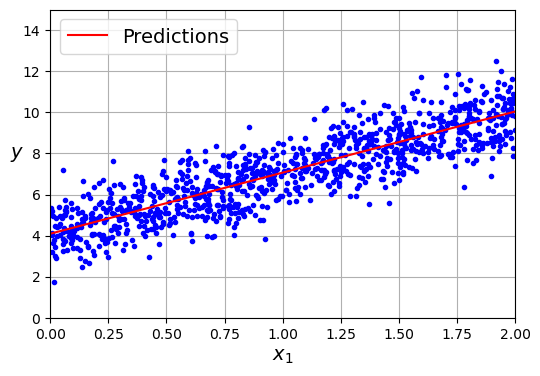

In [21]:
matplotlib.pyplot.figure(figsize=(6, 4))  # extra code – not needed, just formatting
matplotlib.pyplot.plot(X, y, "b.")
matplotlib.pyplot.plot(X_new, y_predict, "r-", label="Predictions")

# extra code – beautifies and saves Figure 4–2
matplotlib.pyplot.xlabel("$x_1$")
matplotlib.pyplot.ylabel("$y$", rotation=0)
matplotlib.pyplot.axis([0, 2, 0, 15])
matplotlib.pyplot.grid()
matplotlib.pyplot.legend(loc="upper left")

matplotlib.pyplot.show()

In [22]:
# scikit-learn을 이용하면 간단하게 할 수 있다

import sklearn.linear_model

lin_reg = sklearn.linear_model.LinearRegression()
lin_reg.fit(X, y)
# intercept_ : bias
# coef_ : weight
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

[4.08996303] [[2.97655156]]
[[ 4.08996303]
 [10.04306616]]


### Pseudoinverse
- Scikit-Learn의 LinearRegression은 scipy.linalg.lstsq()를 사용한다 (Least square).
- 저게 $ \boldsymbol{X}^T \boldsymbol{X} $ 의 inverse를 구하는 대신 pseudoinverse를 구한다
- pseudoinverse를 사용하는 이유는 inverse를 못구하는 일이 발생할 수도 있기 때문. pseudoinverse는 언제나 구할 수 있다
    - single value decomposition (SVD)을 이용해서 matrix를 3개의 component로 나누고 이걸 재조합해서 나오는게 pseudoinverse라고 함

### Computational Complexity
- Inverse matrix를 구하는 complexity는 대략 $O(n^{2.4})$ ~ $O(n^{3})$ 이라고 한다. 즉 n이 늘어날수록 구하는게 엄청나게 어려워져 버린다.
- Scikit-Learn의 SVD approach는 $O(n^{2})$ 이므로 Inverse matrix를 사용하는 것보다 훨씬 낫다
- 일단 한번 구하고 나면 이걸 적용하는건 걍 dot product니까 매우 빠르게 할 수 있다